# Image Classifier Training
**Focus & Astigmatism Detection**
- **Author:** [Aaron Woods](https://aaronwoods.info)
- **Date Created:** October 26, 2023
- **Objective:** To conduct the training phase for the Image Focus and Astigmatism Classifier, encompassing data preparation, model development, and preliminary validation.

**Training Workflow**
1. **Data Loading**: Import and structure the dataset for training.
2. **Preprocessing**: Apply necessary data transformations and augmentations.
3. **Model Training**: Develop and train the classification model.
4. **Initial Validation**: Perform initial tests to assess model accuracy.

**Progression**
- Upon successful completion of this phase, transition to the [Evaluation Notebook](AI_Classify_Eval_v1.ipynb) for in-depth analysis and model refinement.


In [1]:
# Setup Instructions
# 1. Run the shared setup script to prepare the environment and integrate dependencies.
# 2. Execute the setup configurations.

# Import and run the setup function from the setup module
from setup import setup
setup()


No GPU detected. Mixed precision will not be enabled.
Platform: Windows-10-10.0.22621-SP0
Python Version: 3.10.9
TensorFlow Version: 2.10.1
Num GPUs Available: 0


In [2]:
# Standard Libraries
import os
import sys
import random
import math
import glob
import logging
import pickle
from datetime import datetime
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Union, Any, Optional

# Data Manipulation and Numerical Libraries
import numpy as np
import pandas as pd

# Machine Learning and Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight, resample
from sklearn.metrics import confusion_matrix

# Deep Learning with TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, applications

# Image Processing and Visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import itertools

### 0. Configuration

In [3]:
# Configuration

# Experiment Configuration: Sets up the experiment name, random seed, and problem type.
experiment_config = {
    'NAME': "AI_Classify_Train_v1",         # Experiment name       
    'RANDOM_SEED': 42,                      # Seed for reproducibility
    'PROBLEM_TYPE': 'Multi-Output',         # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
}

# Model Configuration: Sets up the model parameters.
model_config = {
    'IMG_SIZE': 224,                        # Image input size
    'BATCH_SIZE': 16,                       # Batch size for training
    'TRAIN_SIZE': 0.8,                      # Fraction of data to use for training
    'VAL_SIZE': 0.5,                        # Fraction of data to use for validation
    'EPOCHS': 10,                          # Number of training epochs
    'LEARNING_RATE': 0.001,                 # Learning rate
    'EARLY_STOPPING_PATIENCE': 50,          # Early stopping patience
    'REDUCE_LR_PATIENCE': 3,                # Reduce learning rate on plateau patience
    'MIN_LR': 1e-6,                         # Minimum learning rate
}

# Label Mapping Configuration: Sets up the label mapping for the dataset. (Optional)
label_mappings = {
    'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
    'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
    'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
}

# Augmentation Configuration: Sets up the augmentation parameters.
augmentation_config = {
    'rotation_factor': 0.002,           # Rotation range (radians)
    'height_factor': (-0.18, 0.18),      # Vertical shift range
    'width_factor': (-0.18, 0.18),       # Horizontal shift range
    'contrast_factor': 0.5,              # Contrast adjustment range
}

# Combine Experiment, Model, Labels, and Augmentation Configurations
config = {
    'Experiment': experiment_config,
    'Model': model_config,
    'Labels': {'MAPPINGS': label_mappings},
    'Augmentation': augmentation_config
}

# Dataset Creation Configuration
csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,                              # Lower focus threshold
        'FOCUS_HIGH': 60,                             # Upper focus threshold
        'STIGX_LOW': 1,                               # Lower astigmatism threshold (X)
        'STIGX_HIGH': 2,                              # Upper astigmatism threshold (X)
        'STIGY_LOW': 1,                               # Lower astigmatism threshold (Y)
        'STIGY_HIGH': 2,                              # Upper astigmatism threshold (Y)
    },
    'Paths': {
        'OLD_BASE_PATH': "D:\\DOE\\",
        # On Simulation Computer
        # 'DATA_FILE': "combined_output.csv", # Simulation Computer
        'DATA_FILE': "combined_output_cleaned.csv", # Laptop
        # 'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",  # Simulation Computer
        'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\", # Laptop
    },
    'SAMPLE_FRAC': 1.0,                                # Fraction of the data for quicker prototyping (1.0 means use all data)
}

# Update the main configuration dictionary with the dataset configuration
config.update(csv_config)

# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

### 1. Data Loading

#### Helper Functions

In [4]:
### Functions for Preparation of CSV

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df


def clean_csv(df: pd.DataFrame, save_cleaned: bool = False) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    
    removal_reasons = defaultdict(list)
    total_rows = len(df)
    csv_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    print("Cleaning CSV file...")
    for index, row in enumerate(df.itertuples()):
        
        image_path = row.ImageFile
        reason = None
        
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        
        if reason:
            removal_reasons[reason].append(index)
    
    invalid_rows = [index for indices in removal_reasons.values() for index in indices]
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("\n\nSummary of row removals:")
    for reason, indices in removal_reasons.items():
        print(f"{len(indices)} rows removed due to: {reason}")
        print(f"Row indices: {indices}")
    
    if save_cleaned and csv_file_path:
        cleaned_csv_file_path = f"{os.path.splitext(csv_file_path)[0]}_cleaned.csv"
        df.to_csv(cleaned_csv_file_path, index=False)
        print(f"Cleaned CSV saved to: {cleaned_csv_file_path}")
    
    return df


In [5]:
### Generating labels

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


In [6]:
### Shuffling and Splitting the Data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

In [7]:
### Computting Class Weights

import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Union
import numpy as np
from collections import Counter

def compute_class_weights_for_label(
    split: str, 
    df: pd.DataFrame, 
    label: str, 
    label_encoders: Dict[str, LabelEncoder], 
    all_records: List[Dict], 
    is_multi_label: bool = False, 
    is_multi_output: bool = False
) -> None:
    if is_multi_output:
        # Logic for multi-output problem types
        y_data = df[label].apply(lambda x: str(x)).values  # Convert to string for consistent handling
        class_weights_dict = get_balanced_class_weights(y_data)
        for cls, weight in class_weights_dict.items():
            cnt = Counter(y_data)[cls]
            # For multi-output, the label encoder per label is used directly
            original_class = label_encoders[label].inverse_transform([int(cls)])[0]
            all_records.append({
                'split': split,
                'label': label,
                'class': original_class,
                'Count': cnt,
                'Weight': weight
            })
    else:
        # Existing logic for single-label or multi-label problems
        y_data = df[label].values if is_multi_label else df[label]
        class_weights_dict = get_balanced_class_weights(y_data)
        for cls, weight in class_weights_dict.items():
            cnt = Counter(y_data)[cls]
            original_class = label_encoders[label].inverse_transform([cls])[0]
            all_records.append({
                'split': split,
                'label': label,
                'class': original_class,
                'Count': cnt,
                'Weight': weight
            })


def get_balanced_class_weights(y_data):
    unique_labels = np.unique(y_data)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=y_data)
    return dict(zip(unique_labels, class_weights))


def compute_and_store_class_weights(
    datasets: Dict[str, pd.DataFrame], 
    label_encoders: Dict[str, LabelEncoder]
) -> pd.DataFrame:
    # Extracting problem type configuration
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    is_multi_output = problem_type == 'Multi-output'
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            compute_class_weights_for_label(
                split, df, label, label_encoders, all_records, 
                is_multi_label=(problem_type == 'Multi-label'),
                is_multi_output=is_multi_output
            )
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights


In [8]:
### Creating Tensorflow Datasets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, applications
from typing import Dict, List, Tuple, Union, Any, Optional

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset: bool = False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    
    def load_and_preprocess_image(file_path: tf.Tensor, label: tf.Tensor, offset: Optional[tf.Tensor], augment: bool = False) -> Tuple:
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        label = tf.cast(label, tf.int32)
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        return (image, label, offset) if include_offset else (image, label)

    def prepare_dataset(file_paths, labels, offsets, augment):
        ds = tf.data.Dataset.from_tensor_slices((file_paths, labels, offsets))
        ds = ds.map(lambda file_path, label, offset: tf.py_function(
            func=load_and_preprocess_image,
            inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment],
            Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
        ))
        return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE) # If I have a lot of memory, I can use cache() here.

    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'
    }

    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets = df[offset_column].values if include_offset else None
                tf_datasets[split][label] = prepare_dataset(df['ImageFile'].values, df[label].values, offsets, augment_data)
        
        elif problem_type == 'Multi-Output':
            labels = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            tf_datasets[split]['Multi_Output'] = prepare_dataset(df['ImageFile'].values, labels, offsets, augment_data)
        
        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets

### Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)

In [9]:
### Resample Datasets to deal with Imbalances (Optional)

def validate_inputs(datasets: Dict[str, pd.DataFrame], resample_label: str, resample_strategy: str) -> None:
    if not isinstance(datasets, dict):
        raise ValueError("Input datasets should be a dictionary.")
    if resample_strategy not in ["upsample", "downsample", "combined"]:
        raise ValueError("Invalid resample_strategy. Choose from 'upsample', 'downsample', or 'combined'.")
    for key, df in datasets.items():
        if resample_label not in df.columns:
            raise ValueError(f"'{resample_label}' is not a valid column in the {key} dataset.")

def target_count_for_strategy(label_counts: pd.Series, strategy: str) -> int:
    if strategy == "downsample":
        return label_counts.min()
    elif strategy == "upsample":
        return label_counts.max()
    return int(label_counts.median())

def iterative_resampling(df: pd.DataFrame, resample_strategy: str, resample_label: str) -> pd.DataFrame:
    label_counts = df[resample_label].apply(tuple).value_counts()
    target_count = target_count_for_strategy(label_counts, resample_strategy)
    subsets = [
        resample(
            df[df[resample_label].apply(tuple) == unique_label],
            replace=(label_counts[unique_label] < target_count),
            n_samples=target_count
        )
        for unique_label in label_counts.keys()
    ]
    return pd.concat(subsets).sample(frac=1).reset_index(drop=True)

def resample_datasets(datasets: Dict[str, pd.DataFrame], resample_label='Multi_Output_Labels', resample_strategy="downsample") -> Dict[str, pd.DataFrame]:
    validate_inputs(datasets, resample_label, resample_strategy)
    
    int32_columns = [col for col, dtype in datasets.get('train', pd.DataFrame()).dtypes.items() if dtype == 'int32']
    
    def process_dataset(key: str, df: pd.DataFrame) -> pd.DataFrame:
        if key != 'train':
            return df
        resampled_data = iterative_resampling(df, resample_strategy, resample_label)
        for col in int32_columns:
            resampled_data[col] = resampled_data[col].astype('int32')
        return resampled_data
    
    return {key: process_dataset(key, df) for key, df in datasets.items()}


#### Main Function

In [10]:
# 🚀 Enhanced Data Loading and Preprocessing Workflow

print("\n🔍 [START] Preprocessing CSV Data...")
data = read_csv(config)
data = update_image_paths(data)
# Uncomment the below line if you want to clean the CSV
# data = clean_csv(data, save_cleaned=False)
data, label_encoders = generate_labels(data)
data = shuffle_and_reset_index(data)
print("\n📊 [LOAD] Preparing TensorFlow Datasets...")
datasets = prepare_datasets(data)
print("  🏋️‍♂️ Computing class weights for original datasets...")
df_class_weights = compute_and_store_class_weights(datasets, label_encoders)
print("\n🔧 [BUILD] Creating TensorFlow datasets from DataFrames...")
datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
print("\n✅ [DONE] Preprocessing Complete!\n")


# print("\n  🔁 Resampling datasets... (Optional)")
# resampled_datasets = resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="upsample")
# rdf_class_weights = compute_and_store_class_weights(resampled_datasets, label_encoders)
# resampled_datasets = create_tf_datasets_from_dfs(resampled_datasets, include_offset=True)
# print("\n✅ [DONE] Resampling Complete!\n")


🔍 [START] Preprocessing CSV Data...
---> Data read successfully.
---> Image paths updated.
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Multi-Output Labels generated.
---> Shuffling and resetting index...
---> Data shuffled and index reset.

📊 [LOAD] Preparing TensorFlow Datasets...
---> Data split into training, validation, and test sets.
  🏋️‍♂️ Computing class weights for original datasets...

🔧 [BUILD] Creating TensorFlow datasets from DataFrames...

✅ [DONE] Preprocessing Complete!



### 2. Dataset Visualization (Optional)

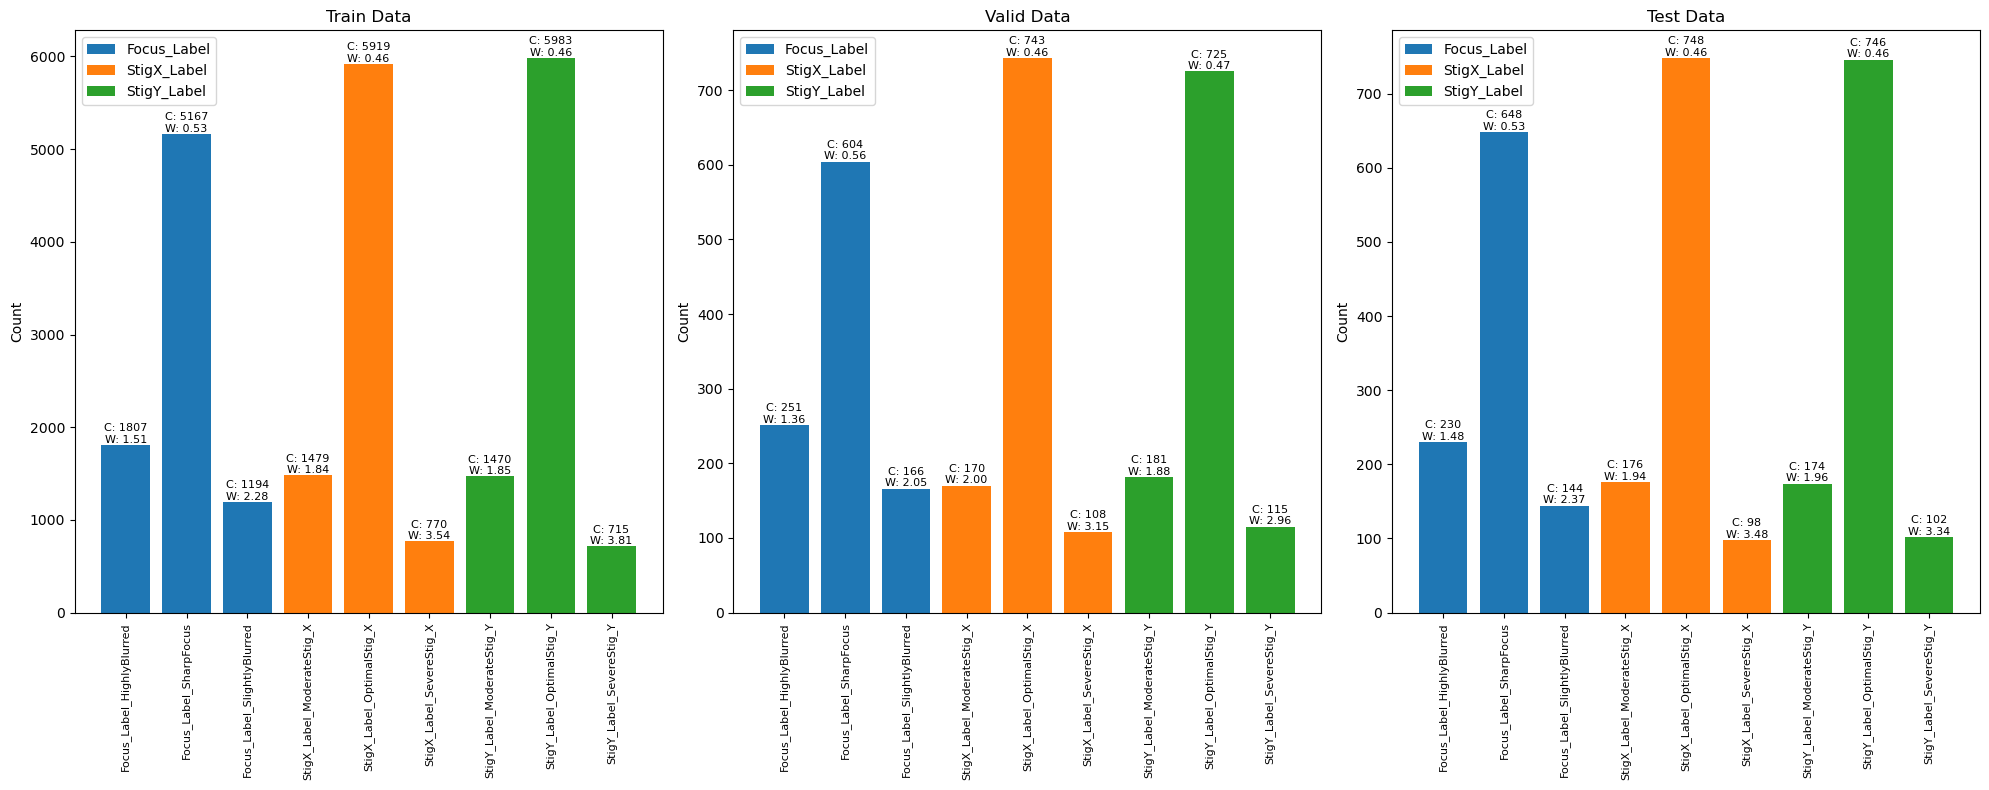

In [11]:
### Class Distributions
import matplotlib.pyplot as plt

def add_annotations(ax, bars, sub_df):
    """
    Adds annotations to the bars.
    """
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height() + 0.5  # Shift annotation slightly above the bar for clarity
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split):
    """
    Plots the class distribution for a single split (train/test/valid).
    """
    filtered_df = df.loc[split]
    x_ticks = []
    x_tick_locs = []
    current_x = 0  # Keep track of the current x-location for ticks
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
        x_tick_locs.extend([current_x + i for i in range(len(sub_df.index))])
        current_x += len(sub_df.index)  # Update the x-location for the next set of bars
    
    ax.legend()
    ax.set_xticks(x_tick_locs)  # Set tick locations
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)  # Set tick labels
    ax.set_title(f"{split.capitalize()} Data")
    ax.set_ylabel("Count")  # Indicate that the bars represent counts


def plot_dataset_info(df):
    """
    Plots the class distribution for train, valid, and test splits.
    """
    splits = ['train', 'valid', 'test']
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split)
        
    plt.tight_layout()
    plt.show()

# Example usage
plot_dataset_info(df_class_weights)
# plot_dataset_info(rdf_class_weights)


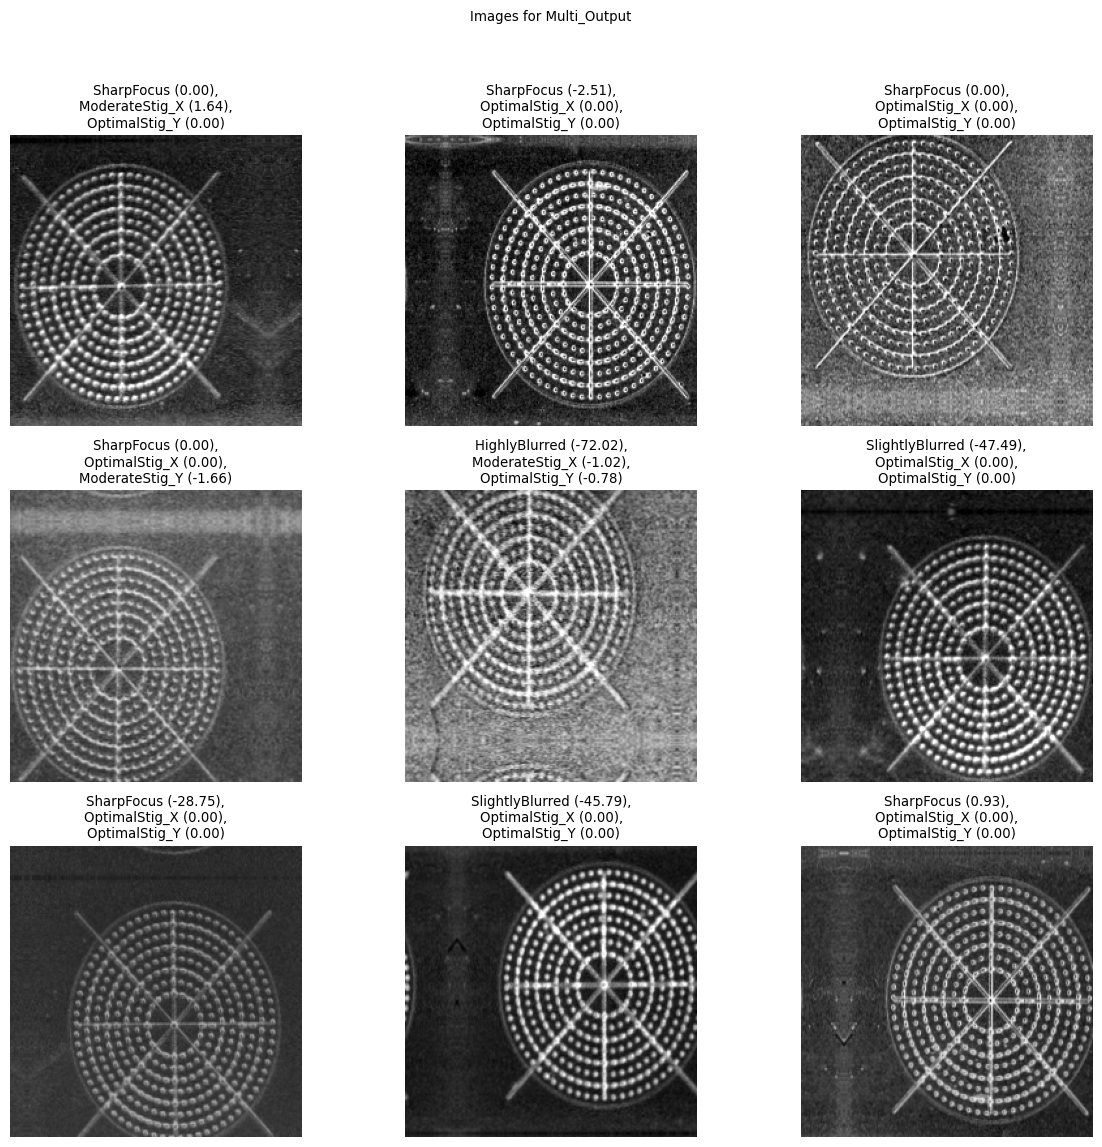

In [12]:
### Plot Images from Dataset

import textwrap
import matplotlib.pyplot as plt

def plot_single_image(ax, image, label_names, offsets):
    """
    Plots a single image with associated labels and offsets.
    """
    ax.imshow(image)
    title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offsets))
    ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to fit into the subplot
    ax.axis("off")

def extract_and_transform_labels(labels, label_keys, label_encoders):
    """
    Extracts and transforms labels using label encoders.
    """
    label_names = []
    for label_value, label_key in zip(labels, label_keys):
        label_encoder = label_encoders.get(label_key, None)
        if label_encoder:
            label_names.append(label_encoder.inverse_transform([label_value])[0])
        else:
            label_names.append(str(label_value))
    return label_names

def plot_images_from_dataset(label_encoders, config, datasets):
    """
    Plots images, labels, and offsets (if available) from the provided datasets.
    
    Args:
        label_encoders (dict): Dictionary of label encoders for each label key.
        config (dict): Configuration dictionary containing problem type and other parameters.
        datasets (dict): Dictionary of datasets, containing training data for each label key.
    """
    label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    problem_type = config['Experiment']['PROBLEM_TYPE']

    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Helper function to get relevant dataset based on problem type
    def get_relevant_dataset(problem_type, label_key):
        return datasets['train'][label_key if problem_type in ['Multi-Class', 'Binary'] else 'Multi_Output']

    # If problem type is not Multi-Output, re-use the same logic for both Binary and Multi-Class
    relevant_datasets = [label_keys] if problem_type != "Multi-Output" else ["Multi_Output"]

    for label_key in relevant_datasets:
        label_encoder = label_encoders.get(label_key, None)
        fig.suptitle(f"Images for {label_key}")

        for data in get_relevant_dataset(problem_type, label_key).take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None

            for i in range(min(len(images), 9)):
                ax = axes[i // 3, i % 3]
                current_labels = labels[i].numpy() if problem_type == "Multi-Output" else [labels[i].numpy()]
                current_offsets = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
                # Round offsets to 2 decimal places
                current_offsets = [f"{offset:.2f}" for offset in current_offsets]

                label_names = extract_and_transform_labels(current_labels, label_keys, label_encoders)
                plot_single_image(ax, images[i].numpy(), label_names, current_offsets)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if problem_type not in ["Multi-Class", "Binary", "Multi-Output"]:
        print("Unknown problem type specified in config. Please check.")

# Example usage (assuming label_encoders, config, and datasets are defined elsewhere)
plot_images_from_dataset(label_encoders, config, datasets)


### 3. Creating Classification Models

In [13]:
### Model Building (Define the Model)

def add_multi_output_heads(base_layer, num_classes: int, output_names: List[str]) -> List[keras.layers.Layer]:
    """Creates multiple output heads for a given base layer."""
    outputs = []
    for i in range(num_classes):
        x = layers.Dense(128, activation="relu")(base_layer)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(3, activation="softmax", name=output_names[i])(x)  # Naming each output layer
        outputs.append(x)
    return outputs

def determine_activation_and_units(num_classes: int) -> Tuple[List[str], List[int]]:
    """Determines the activation functions and units based on the number of classes and config settings."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type in ['Multi-Label', 'Binary', 'Multi-Class', 'Multi-Output']:
        return {
            'Multi-Label': (["sigmoid"] * num_classes, [1] * num_classes),
            'Binary': (["sigmoid"], [1]),
            'Multi-Class': (["softmax"], [num_classes]),
            'Multi-Output': (["softmax"] * num_classes, [3] * num_classes)  # Assuming each output has 3 classes
        }[problem_type]
    raise ValueError(f"Invalid problem_type: {problem_type}")

def create_transfer_model(base_model, input_shape: Tuple[int, int, int], num_classes: int, hidden_units: List[int], dropout_rate: float, regularizer_rate: float, output_names: List[str] = None) -> keras.Model:
    """Creates a transfer learning model based on the provided base model."""
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])
    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
    
    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        model.add(layers.Dense(units_list[0], activation=activations[0]))
        return model
    
    # output_names = output_names or list(config['Labels']['MAPPINGS'].keys())
    output_names = list(config['Labels']['MAPPINGS'].keys())

    outputs = add_multi_output_heads(model.layers[-1].output, num_classes, output_names)
    return keras.Model(inputs=model.input, outputs=outputs)

def create_specific_transfer_model(base_model_class, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Helper function to create specific transfer models."""
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())

def create_mobilenetv2_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.MobileNetV2, input_shape, num_classes)

def create_inceptionv3_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.InceptionV3, input_shape, num_classes)

def create_resnet50_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.ResNet50, input_shape, num_classes)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    inputs = keras.Input(shape=input_shape)

    x = inputs

    for _ in range(num_conv_blocks):
        x = layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=dense_activation)(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

In [14]:
import os
import tensorflow as tf
from datetime import datetime
from keras import callbacks
from typing import List, Optional

# Constants & Configurations for Loss and Metrics
LOSS_CONFIG = {
    'Binary': 'binary_crossentropy',
    'Multi-Class': 'categorical_crossentropy',
    'Multi-Output': lambda num_outputs: ['categorical_crossentropy'] * num_outputs,
    'Multi-Label': 'binary_crossentropy'
}

RECOMMENDED_METRICS = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': lambda metrics, num_outputs: [metric for _ in range(num_outputs) for metric in metrics],
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}

# Helper Functions
def get_accuracy_metric(problem_type: str) -> str:
    return {
        'Binary': "accuracy",
        'Multi-Label': "binary_accuracy"
    }.get(problem_type, "categorical_accuracy")

def create_directory(path: str):
    """Create a directory if it does not exist."""
    os.makedirs(path, exist_ok=True)

# Callback Setup Functions
def setup_common_callbacks(config: dict) -> List[callbacks.Callback]:
    """Setup common callbacks for training."""
    return [
        callbacks.EarlyStopping(patience=config['Model']['EARLY_STOPPING_PATIENCE'], restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR'])
    ]

def setup_specific_callbacks(model_name: str, model_dir: str, problem_type: str, config: dict, log_dir: Optional[str] = None) -> List[callbacks.Callback]:
    """Setup specific callbacks for a given model."""
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"The specified model directory {model_dir} does not exist.")

    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    acc_metric = get_accuracy_metric(problem_type)
    checkpoint_filename = f"{model_name}_epoch_{{epoch:02d}}_val_loss_{{val_loss:.2f}}_{acc_metric}_{{{{val_{acc_metric}:.2f}}}}.h5"
    checkpoint_path = os.path.join(model_dir, checkpoint_filename)

    tensorboard_log_dir = log_dir if log_dir else os.path.join(model_dir, "logs", f"{model_name}_{problem_type}_{datetime_str}")

    return [
        callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        callbacks.TensorBoard(log_dir=tensorboard_log_dir)
    ]

def compile_model(model_name, input_shape, num_classes, problem_type, model_dir, config: dict):
    """Compile the model with appropriate configurations."""
    model = select_model(model_name, input_shape, num_classes)  # select_model function needs to be defined elsewhere
    metrics_to_use = RECOMMENDED_METRICS.get(problem_type, ['accuracy'])
    loss_to_use = LOSS_CONFIG.get(problem_type, 'categorical_crossentropy')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(config['Model']['LEARNING_RATE']), 
        loss=loss_to_use, 
        metrics=metrics_to_use
    )

    model_architecture_path = os.path.join(model_dir, f"{model_name}_architecture.png")
    tf.keras.utils.plot_model(model, to_file=model_architecture_path, show_shapes=True)
    return model


def compile_and_initialize_models(config: dict) -> Dict[str, Dict[str, tf.keras.Model]]:
    """
    Compile and initialize models based on the provided configuration.

    Args:
    - config: A dictionary containing model and experiment configuration details.

    Returns:
    - A dictionary of compiled models, indexed by model name, each containing the model instance and associated callbacks.
    """
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = len(config['Labels']['MAPPINGS'])
    problem_type = config['Experiment']['PROBLEM_TYPE']

    experiment_name = config['Experiment']['NAME']
    base_dir = os.path.join(".", experiment_name)
    create_directory(base_dir)

    common_callbacks = setup_common_callbacks(config)
    label_names = config['Labels']['MAPPINGS'].keys() if problem_type == 'Multi-Class' else ['']

    compiled_models = {}
    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        create_directory(label_dir)

        for model_name in config['Model']['MODEL_NAMES']:
            model_dir = os.path.join(label_dir, model_name)
            create_directory(model_dir)
            
            specific_callbacks = setup_specific_callbacks(model_name, model_dir, problem_type, config)
            all_callbacks = common_callbacks + specific_callbacks
            
            model = compile_model(model_name, input_shape, num_classes, problem_type, model_dir, config)
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
    
    return compiled_models

model_names = ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']
config['Model']['MODEL_NAMES'] = model_names

# Execution
compiled_models = compile_and_initialize_models(config)
print("Models compiled and initialized successfully.")


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Models compiled and initialized successfully.


### 4. Model Training

In [15]:
### Inspect Dataset Content and Split into Test, Train, and Validation

def inspect_dataset_content(dataset, name, num_batches=3, max_unique_values=10):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in record.items()}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for tensor_name, tensor in batch.items():
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in {tensor_name}: {unique_values[:max_unique_values]}")
            if len(unique_values) > max_unique_values:
                print(f"...and {len(unique_values) - max_unique_values} more unique values.")
        print("------")


def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors
    # return tensors[0], tensors[1], tensors[2]  # Return image, label, and offset tensors

def get_dataset(raw_datasets, dataset_type):
    """Retrieve specific dataset type (train, valid, test) from the raw datasets dictionary."""
    return raw_datasets.get(dataset_type, {}).get('Multi_Output')

def prepare_and_inspect_dataset(dataset, dataset_name):
    """Apply transformations and inspect a dataset."""
    if dataset is None:
        print(f"{dataset_name} dataset is None. Skipping.")
        return None

    dataset = dataset.map(select_tensors)
    # inspect_dataset_content(dataset, dataset_name)
    
    return dataset

def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Returns:
    - A tuple containing prepared TensorFlow datasets for training, validation, and testing.
    """
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None, None, None

    train_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'train'), 'Train')
    valid_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'valid'), 'Validation')
    test_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'test'), 'Test')
    
    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)
# train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(resampled_datasets)


#### Helper Functions

In [16]:
import gc
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from collections import Counter
import traceback

def clear_keras_model_from_memory(model):
    """ Clears TensorFlow Keras model from memory. """
    K.clear_session()
    del model
    gc.collect()

def display_debug_info(enabled, title, details):
    """ Displays debug information if enabled. """
    if enabled:
        print(f"\n--- {title} ---")
        for key, value in details.items():
            print(f"{key}: {value}")

def prepare_class_weights(model, weights):
    """ Prepares class weights for the model. """
    output_layers = [layer.name for layer in model.layers if 'output' in layer.name]
    prepared_weights = {}
    warnings = []
    for layer_name in output_layers:
        if layer_name in weights:
            prepared_weights[layer_name] = weights[layer_name]
        else:
            warnings.append(f"Warning: Missing class weight for {layer_name}.")
    return prepared_weights, warnings

def execute_model_training(model_info, training_data, validation_data, weights, model_identifier, num_epochs, type_of_problem, clear_mem=True, debug=False):
    """ Executes the model training process. """
    try:
        model = model_info['model']
        callbacks = model_info.get('callbacks', [])

        display_debug_info(debug, "Training Details", {
            "Model": model_identifier,
            "Type": type_of_problem,
            "Epochs": num_epochs,
            "Callbacks Count": len(callbacks)
        })

        weights, weight_warnings = prepare_class_weights(model, weights)
        for warning in weight_warnings:
            print(warning)
        display_debug_info(debug, "Class Weights", weights)

        training_history = model.fit(
            training_data,
            validation_data=validation_data,
            epochs=num_epochs,
            callbacks=callbacks,
            class_weight=weights
        )

        if clear_mem:
            clear_keras_model_from_memory(model)

        print(f"\nCompleted training for {model_identifier}.")
        return training_history

    except tf.errors.OpError as error:
        report_exception(error, f"TensorFlow error during training of {model_identifier}")
    except KeyError as error:
        report_exception(error, f"Key error: {error}. Incomplete model info for {model_identifier}.")
    except Exception as error:
        report_exception(error, f"Unexpected error while training {model_identifier}")

def report_exception(exc, custom_message):
    """ Reports an exception with a custom message. """
    print(custom_message)
    traceback.print_exc()

def fetch_latest_checkpoint(checkpoint_dir):
    """ Retrieves the latest checkpoint file from a directory. """
    checkpoint_files = [file for file in os.listdir(checkpoint_dir) if file.endswith('.h5')]
    return os.path.join(checkpoint_dir, sorted(checkpoint_files, reverse=True)[0]) if checkpoint_files else None

def store_training_metrics(training_history, model_identifier, experiment_config):
    """ Stores the training metrics in a CSV file. """
    file_name = f"{experiment_config['Experiment']['NAME']}_{model_identifier}_metrics.csv"
    file_path = os.path.join("./", file_name)

    metrics_df = pd.DataFrame(training_history.history)
    write_mode = 'a' if os.path.exists(file_path) else 'w'
    metrics_df.to_csv(file_path, mode=write_mode, header=not os.path.exists(file_path))
    print(f"Metrics for {model_identifier} stored at {file_path}")

def validate_datasets(*datasets):
    """ Validates the presence of required datasets. """
    return all(datasets)

def debug_log(enabled, header, *messages):
    """ Logs debug messages if enabled. """
    if enabled:
        print(f"\n--- {header} ---")
        for message in messages:
            print(message)

def process_and_record_models(training_data, validation_data, testing_data, models, class_weights, configuration, debug=False):
    """ Processes models, records metrics, and handles errors. """
    if not validate_datasets(training_data, validation_data, testing_data):
        print("Missing one or more datasets. Aborting process.")
        return

    debug_log(debug, "Model Details", *(f"Model: {name}, Type: {type(info['model'])}, Callbacks: {len(info['callbacks'])}" for name, info in models.items()))

    epochs = configuration['Model']['EPOCHS']
    problem_type = configuration['Experiment']['PROBLEM_TYPE']
    
    for model_name, model_info in models.items():
        try:
            history = execute_model_training(model_info, training_data, validation_data, class_weights, model_name, epochs, problem_type, clear_mem=True, debug=debug)
            if history:
                store_training_metrics(history, model_name, configuration)
            debug_log(debug, f"Model {model_name} Training", "Completed Successfully")
        except Exception as e:
            print(f"Error with model {model_name}: {e}")
            continue

    print("\nAll models have been trained.")

# Function call to train and save metrics
process_and_record_models(train_dataset, valid_dataset, test_dataset, compiled_models, df_class_weights, config, debug=True)



--- Model Details ---
Model: mobilenetv2, Type: <class 'keras.engine.functional.Functional'>, Callbacks: 4
Model: inceptionv3, Type: <class 'keras.engine.functional.Functional'>, Callbacks: 4
Model: resnet50, Type: <class 'keras.engine.functional.Functional'>, Callbacks: 4
Model: small_xception, Type: <class 'keras.engine.functional.Functional'>, Callbacks: 4
Model: basic_cnn, Type: <class 'keras.engine.functional.Functional'>, Callbacks: 4

--- Training Details ---
Model: mobilenetv2
Type: Multi-Output
Epochs: 10
Callbacks Count: 4

--- Class Weights ---


Epoch 1/10
Unexpected error while training mobilenetv2

--- Model mobilenetv2 Training ---
Completed Successfully

--- Training Details ---
Model: inceptionv3
Type: Multi-Output
Epochs: 10
Callbacks Count: 4

--- Class Weights ---
Epoch 1/10


Traceback (most recent call last):
  File "C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_5700\3132997439.py", line 52, in execute_model_training
    training_history = model.fit(
  File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\AARON~1.WOO\AppData\Local\Temp\__autograph_generated_fileacy7ws4q.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
TypeError: in user code:

    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given



Unexpected error while training inceptionv3

--- Model inceptionv3 Training ---
Completed Successfully

--- Training Details ---
Model: resnet50
Type: Multi-Output
Epochs: 10
Callbacks Count: 4

--- Class Weights ---
Epoch 1/10


Traceback (most recent call last):
  File "C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_5700\3132997439.py", line 52, in execute_model_training
    training_history = model.fit(
  File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\AARON~1.WOO\AppData\Local\Temp\__autograph_generated_fileacy7ws4q.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
TypeError: in user code:

    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given



Unexpected error while training resnet50

--- Model resnet50 Training ---
Completed Successfully

--- Training Details ---
Model: small_xception
Type: Multi-Output
Epochs: 10
Callbacks Count: 4

--- Class Weights ---
Epoch 1/10
Unexpected error while training small_xception


Traceback (most recent call last):
  File "C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_5700\3132997439.py", line 52, in execute_model_training
    training_history = model.fit(
  File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\AARON~1.WOO\AppData\Local\Temp\__autograph_generated_fileacy7ws4q.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
TypeError: in user code:

    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given




--- Model small_xception Training ---
Completed Successfully

--- Training Details ---
Model: basic_cnn
Type: Multi-Output
Epochs: 10
Callbacks Count: 4

--- Class Weights ---
Epoch 1/10
Unexpected error while training basic_cnn

--- Model basic_cnn Training ---
Completed Successfully

All models have been trained.


Traceback (most recent call last):
  File "C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_5700\3132997439.py", line 52, in execute_model_training
    training_history = model.fit(
  File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\AARON~1.WOO\AppData\Local\Temp\__autograph_generated_fileacy7ws4q.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
TypeError: in user code:

    File "c:\Users\aaron.woods\AppData\Local\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given

Traceback (most recent call last):
  File "C:\Users\aaron.woods\AppData\Local\Temp\ipyke

# Debugging and Investigation Zone

In [17]:
### Investigating Model Outputs


for label_category, encoder in label_encoders.items():
    print(f'Mapping for {label_category}:')
    for index, class_label in enumerate(encoder.classes_):
        print(f'{index}: {class_label}')
    print()  # print a blank line between categories



def analyze_model_outputs(compiled_models, train_dataset):
    model_output_details = []
    
    # Assuming train_dataset is an iterable that yields batches of data,
    # We'll take the first batch of images from the training dataset for analysis.
    for images, labels in train_dataset.take(1):
        image_batch = images.numpy()  # Convert tensors to numpy arrays if necessary

    # Order of label encoders corresponding to the outputs
    encoder_order = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    
    for model_name, model_details in compiled_models.items():
        model = model_details['model']
        output = model.predict(image_batch)
        
        if not isinstance(output, list):
            output = [output]  # Ensure output is a list for consistency
        
        for i, output_to_check in enumerate(output):
            one_hot_encoded = all((np.sum(row) > 0.99 and np.sum(row) < 1.01) for row in output_to_check)
            suggested_loss = 'categorical_crossentropy' if one_hot_encoded else 'sparse_categorical_crossentropy'
            max_prob_class = np.argmax(output_to_check, axis=-1)
            
            # Get the label encoder for the current output
            encoder_key = encoder_order[i] if i < len(encoder_order) else None
            label_encoder = label_encoders[encoder_key] if encoder_key else None
            
            # Decode the sample output
            sample_output = output_to_check[0] if len(output_to_check) > 0 else "No Output"
            sample_output_decoded = label_encoder.inverse_transform([np.argmax(sample_output)])[0] if label_encoder else "No Decoder"
            
            model_output_details.append({
                "Model Name": model_name,
                # Include Output Layer Name 
                "Output Layer Name": model.output_names[i],
                "Output": f'Output {i+1}',
                "Input Shape": model.input_shape,
                "Output Shape": output_to_check.shape,
                "Output Type": type(output).__name__,
                "Is One-Hot Encoded": one_hot_encoded,
                "Suggested Loss": suggested_loss,
                "Max Probability Class": max_prob_class,
                "Sample Output": sample_output,
                "Sample Output (Decoded)": sample_output_decoded
            })

    return pd.DataFrame(model_output_details).style.set_table_styles(
        [{"selector": "th", "props": [("font-size", "100%"), ("text-align", "center")]},
         {"selector": "td", "props": [("font-size", "100%"), ("text-align", "center")]}]
    )

# Assuming train_dataset is already defined and loaded with your training data
# Display the analysis
# analyze_model_outputs(compiled_models, train_dataset)

Mapping for Focus_Label:
0: HighlyBlurred
1: SharpFocus
2: SlightlyBlurred

Mapping for StigX_Label:
0: ModerateStig_X
1: OptimalStig_X
2: SevereStig_X

Mapping for StigY_Label:
0: ModerateStig_Y
1: OptimalStig_Y
2: SevereStig_Y

